In [208]:
import time
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

# Ordinary Differential Equations (ODEs)

## Analytical solution

We model a batch reactor. In the batch reactor, component $A$ reacts to component $B$ with the rate constant $k=0.2\, min^{-1}$.

$A \xrightarrow{k} B$

The resulting evolution of component concentrations $C_A$ and $C_B$ are:

$\frac{dC_A}{dt}=-kC_A$

$\frac{dC_B}{dt}=kC_A$

At the beginning of the reaction, only $A$ present (initial condition).

$C_A(t=0\,s)=1\, mol/L$

$C_B(t=0\,s)=0\, mol/L$

Define parameters.

In [127]:
# time domain
t_start = 0.0
t_end = 30.0
n = 500
t = np.linspace(t_start, t_end, n)
dt = t[1]-t[0]

# initial condition
cA_0 = 1.0
cA_0 = 0.0

# kinetic constant
k = 0.2

Define analytical solution.

$C_A(t)=e^{-kt}\, mol/L$

$C_B(t)=1-e^{-kt}\, mol/L$

In [128]:
def cA(k: float, t: float) -> float:
    return np.exp(-k*t)

def cB(k: float, t: float) -> float:
    return 1 - np.exp(-k*t)

Plot the results.

/tmp/ipykernel_1919/180251460.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


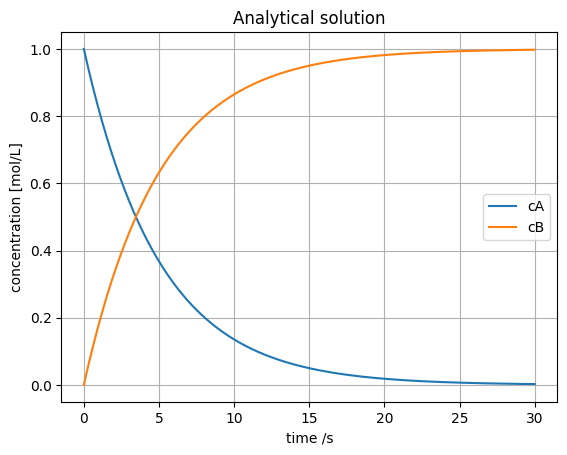

In [129]:
fig, ax = plt.subplots()
ax.plot(t, cA(k, t), label = "cA")
ax.plot(t, cB(k, t), label = "cB")
ax.set_xlabel("time /s")
ax.set_ylabel("concentration [mol/L]")
ax.set_title("Analytical solution")
ax.legend()
ax.grid()
fig.show()

## Analytical solution - linear system of ODEs

Solve the following reaction system analytically.

$A \xrightleftharpoons[k_2]{k_1} B \xrightleftharpoons[k_4]{k_3} C$

Initial conditions:

$C_A(0)=1\, mol/L$

$C_B(0)=C_C(0)=0\, mol/L$

Rate constants:

$k_1=1\, min^{-1}, k_2=0\, min^{-1}, k_3=2\, min^{-1}, k_4=3\, min^{-1}$


Define parameters.

In [130]:
# initial condition
c_0 = np.array([1,0,0])

In [131]:
# matrix of the rates
K = np.array([[-1,0,0],[1,-2,3],[0,2,-3]])

Calculate exponential of matrix.

Note: `expm` vs `exp` in scipy
- `exmp`: matrix exponentiation $e^A=Ue^\lambda U^{-1}$
- `exp`: scalar value exponentiation $e^x, x \in \mathbb{R}$


In [132]:
eK = K * dt
eKdt = sp.linalg.expm(eK)

In [133]:
C = [c_0]
for i in range(len(t)-1):
    c_0 = np.dot(eKdt,c_0)
    C.append(c_0)

In [134]:
# extract values
cA = [array[0] for array in C]
cB = [array[1] for array in C]
cC = [array[2] for array in C]

Plot the results.

/tmp/ipykernel_1919/2965777143.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


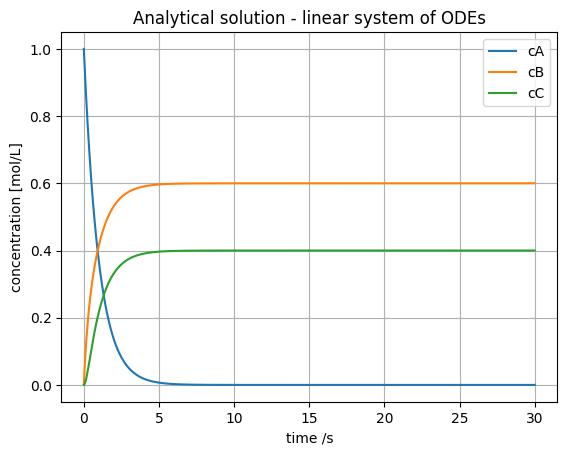

In [135]:
fig, ax = plt.subplots()
ax.plot(t, cA, label = "cA")
ax.plot(t, cB, label = "cB")
ax.plot(t, cC, label = "cC")
ax.set_xlabel("time /s")
ax.set_ylabel("concentration [mol/L]")
ax.set_title("Analytical solution - linear system of ODEs")
ax.legend()
ax.grid()
fig.show()

# Initial value problems (IVPs)

## The Forward Euler method

We analyze the semi-batch reactor. The reactor model contains a non-autonomous term (right hand-side contains the independent variable $t$ explicitly).

$\frac{dC_A}{dt}=\frac{\dot{V}}{V_0+\dot{V}t}\left(C_A^{in}-C_A\right)-kC_A$

$\frac{dC_B}{dt}=kC_A$

Initial contitions:

$C_A(t=0\,s)=1\, mol/L,\; C_B(0)=0\, mol/L$


Define the reaction system.

In [159]:
# reaction system
def dC(t, c):
    cA, _ = c
    k = 0.2
    Vdot = 0.1
    V_0 = 10
    cA_in = 0.5
    dcA = Vdot/(V_0+Vdot*t)*(cA_in-cA)-k*cA
    dcB = k*cA
    return np.array([dcA, dcB])

Define forward euler method.

In [160]:
def forward_euler(func: Callable, y0: np.ndarray, t: np.ndarray) -> np.ndarray:
    y = np.zeros((len(y0),len(t)))
    h = t[1]-t[0]
    # initial condition
    y[:,0] = y0
    for i in range(1,len(t)):
        y[:,i] = y[:,i-1]+h*func(t[i-1], y[:,i-1])
    return y

Execute forward euler method.

In [161]:
c0 = np.array([1,0])
c = forward_euler(dC, c0, t)

Plot the results.

/tmp/ipykernel_1919/473474845.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


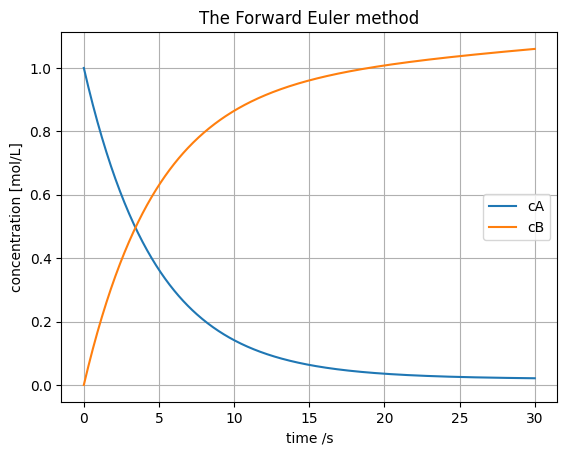

In [162]:
fig, ax = plt.subplots()
ax.plot(t, c[0,:], label = "cA")
ax.plot(t, c[1,:], label = "cB")
ax.set_xlabel("time /s")
ax.set_ylabel("concentration [mol/L]")
ax.set_title("The Forward Euler method")
ax.legend()
ax.grid()
fig.show()

## The Backward Euler method

Define chemical reaction system.

In [163]:
# reaction system
def dC(t, c):
    cA, _ = c
    k = 0.2
    Vdot = 0.1
    V_0 = 10
    cA_in = 0.5
    dcA = Vdot/(V_0+Vdot*t)*(cA_in-cA)-k*cA
    dcB = k*cA
    return np.array([dcA, dcB])

Define backward euler method.

In [164]:
import numpy as np

def backward_euler_fixed_point(func, y0, t, tol=1e-6, max_iter=100):
    """
    Solves the ODE y' = f(t, y) using the Backward (Implicit) Euler method
    with fixed-point iteration.

    Parameters:
    func : function
        Function that defines the ODE (y' = func(t, y)).
    y0 : float
        Initial condition.
    tol : float
        Tolerance for the fixed-point iteration (default is 1e-6).
    max_iter : int
        Maximum number of iterations for the fixed-point iteration (default is 100).

    Returns:
    t : numpy.ndarray
        Array of time points.
    y : numpy.ndarray
        Array of solution values at the time points.
    """    
    # Initialize arrays for time and solution values
    y = np.zeros([len(y0),len(t)])
    y[:,0] = y0
    dt = t[1]-t[0]

    # Iterate over each time step
    for n in range(len(t)-1):
        # Initial guess for y_{i+1}
        y_next = y[:,n]
        
        # Fixed-point iteration to solve for y_{i+1}
        for i in range(max_iter):
            y_new = y[:,n] + dt * func(t[n+1], y_next)
            if max(np.abs(y_new - y_next)) < tol:
                break
            y_next = y_new
        
        # Update solution
        y[:,n+1] = y_next
    
    return y

Execute backward euler method.

In [165]:
y0 = np.array([1,0])

c = backward_euler_fixed_point(dC, y0, t)

Plot the results.

/tmp/ipykernel_1919/867519252.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


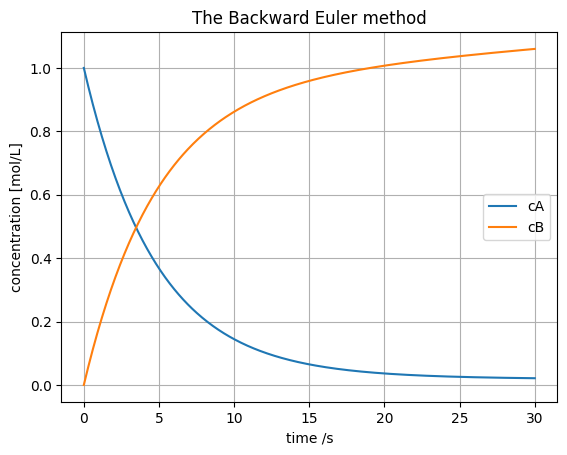

In [166]:
fig, ax = plt.subplots()
ax.plot(t, c[0,:], label = "cA")
ax.plot(t, c[1,:], label = "cB")
ax.set_xlabel("time /s")
ax.set_ylabel("concentration [mol/L]")
ax.set_title("The Backward Euler method")
ax.legend()
ax.grid()
fig.show()

## Errors in numerical solution of ODEs and stability

### Numerical error

Define a fine and a coarse time grid.

In [621]:
t_coarse = np.linspace(0,30,11)
t_fine = np.linspace(0,30,101)

In [622]:
def cA_analytical(k: float, t: float) -> float:
    return np.exp(-k*t)

In [623]:
def dC(t, c):
    return -0.2*c

In [624]:
start_coarse = time.time()
c_coarse = forward_euler(dC, c0, t_coarse)
end_coarse = time.time()
time_coarse = end_coarse - start_coarse
print(f"Euler method for coarse grid took {round(time_coarse, 4)} seconds.")

start_fine = time.time()
c_fine = forward_euler(dC, c0, t_fine)
end_fine = time.time()
time_fine = end_fine - start_fine
print(f"Euler method for fine grid took {round(time_fine, 4)} seconds.")

Euler method for coarse grid took 0.0003 seconds.
Euler method for fine grid took 0.0028 seconds.


/tmp/ipykernel_1919/2652020458.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


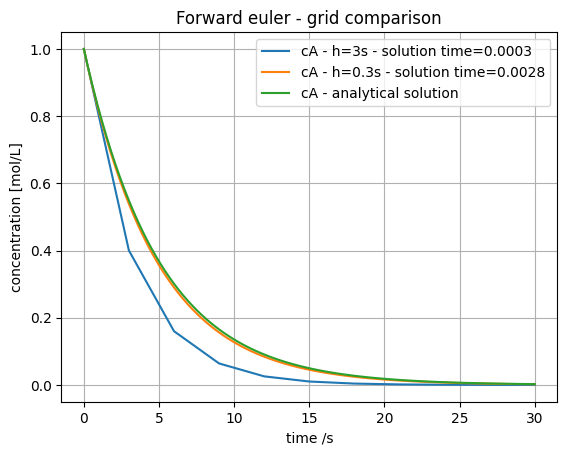

In [625]:
fig, ax = plt.subplots()
ax.plot(t_coarse, c_coarse[0,:], label = f"cA - h=3s - solution time={round(time_coarse, 4)}")
ax.plot(t_fine, c_fine[0,:], label = f"cA - h=0.3s - solution time={round(time_fine, 4)}")
ax.plot(t_fine, cA_analytical(0.2, t_fine), label = "cA - analytical solution")
ax.set_xlabel("time /s")
ax.set_ylabel("concentration [mol/L]")
ax.set_title("Forward euler - grid comparison")
ax.legend()
ax.grid()
fig.show()

### Stability

## SciPy's `solve_ivp`

We analyze the same system as for [Analytical solution - linear system of ODEs](#Analytical-solution-linear-system-of-ODEs).

Define the reaction system.

In [626]:
# rate constants 
k = [1, 0, 2, 3]

In [627]:
# initial condition
c_0 = np.array([1,0,0])

In [628]:
# reaction system
def dC(t, c, k):
    dcA = -k[0]*c[0]+k[1]*c[1]
    dcB = k[0]*c[0]+k[3]*c[2]-(k[1]+k[2])*c[1]
    dcC = -k[3]*c[2]+k[2]*c[1]
    return [dcA, dcB, dcC]

Solve the IVP using SciPy's `solve_ivp` function.

In [629]:
results = sp.integrate.solve_ivp(dC, (t[0],t[-1]), c_0, t_eval=t, args=(k,))
cA = results['y'][0]
cB = results['y'][1]
cC = results['y'][2]

Plot the results.

/tmp/ipykernel_1919/3777440651.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


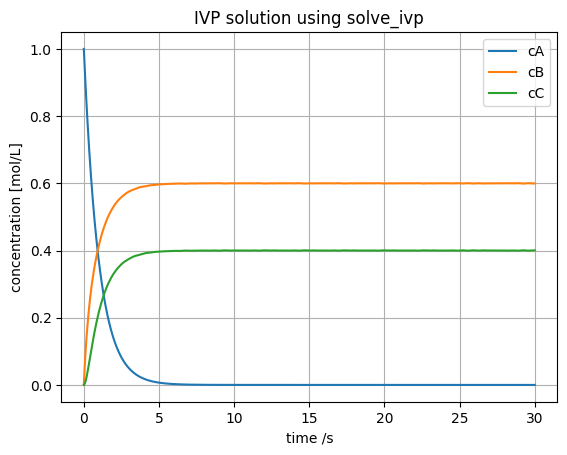

In [630]:
fig, ax = plt.subplots()
ax.plot(t, cA, label = "cA")
ax.plot(t, cB, label = "cB")
ax.plot(t, cC, label = "cC")
ax.set_xlabel("time /s")
ax.set_ylabel("concentration [mol/L]")
ax.set_title("IVP solution using solve_ivp")
ax.legend()
ax.grid()
fig.show()